In [1]:
import numpy as np
import pandas as pd
from io import BytesIO
from azure.storage.blob import BlobServiceClient
from src.paychex_ml.utils import load_credentials
import matplotlib.pyplot as plt

In [2]:
credentials = load_credentials("blob_storage",
                               file="C:/Users/bruno.gonzalez/DataspellProjects/Paychex_revenue_forecast/credentials.yml")

In [3]:
# Start client
container_name = "clean-data"
blob_service_client = BlobServiceClient.from_connection_string(credentials['conn_string'])
container_client = blob_service_client.get_container_client(container_name)

# Download file
file = 'table_predictable.csv'
stream_downloader = container_client.download_blob(file)
with BytesIO() as stream:
    stream_downloader.readinto(stream)
    stream.seek(0)
    df = pd.read_csv(stream, dtype={'Period':str, 'Calendar Date': str})

In [4]:
items = ['401K Asset fee & BP Revenue',
         '401K Fee Revenue',
         'ASO Allocation',
         'ASO Revenue - Oasis',
         'Benetrac',
         'Cafeteria Plans Revenue',
         'Delivery Revenue',
         'Emerging Products',
         'ESR Revenue',
         'Full Service Unemployment Revenue',
         'Health Benefits',
         'HR Online',
         'HR Solutions (PEO)',
         'Interest on Funds Held for Clients',
         'Other Processing Revenue',
         'Payroll blended products',
         'SurePayroll.',
         'Time & Attendance',
         'Total international',
         'Total Paychex Advance',
         'Total PEO',
         'W-2 Revenue',
         'Workers Comp - Payment Services'
         ]

In [5]:
df = df[(df['Scenario']=='Actual')&(df['Item'].isin(items))]\
    .groupby(['Calendar Date', 'Item']).sum()\
    .unstack(level=1)['Value']

In [6]:
df.head()

Item,401K Asset fee & BP Revenue,401K Fee Revenue,ASO Allocation,ASO Revenue - Oasis,Benetrac,Cafeteria Plans Revenue,Delivery Revenue,ESR Revenue,Emerging Products,Full Service Unemployment Revenue,...,Interest on Funds Held for Clients,Other Processing Revenue,Payroll blended products,SurePayroll.,Time & Attendance,Total PEO,Total Paychex Advance,Total international,W-2 Revenue,Workers Comp - Payment Services
Calendar Date,,,,,,,,,,,,,,,,,,,,,
20140601,4261452.0,10621963.0,7255027.55,0.0,1922941.0,1714950.0,7393351.97,47602.0,796063.0,1869396.0,...,3308154.0,4765775.19,99633512.0,3246967.02,4651817.0,12948696.0,0.0,808003.64,7031234.09,4858397.0
20140701,4513388.0,10558382.0,9070820.80,0.0,1916579.0,1698495.0,13513741.18,67521.0,986955.0,2341533.0,...,3466375.0,6502729.54,121619696.0,3362473.02,5165885.0,14670286.0,0.0,855305.18,7325377.82,5244318.0
20140801,4486436.0,10297495.0,7489159.50,0.0,1944830.0,1829118.0,7286966.62,79771.0,924689.0,1986835.0,...,3434419.0,4215268.17,99472483.0,3286111.93,4856677.0,14606689.0,0.0,801651.38,7443620.46,5588578.0
20140901,4355891.0,12719409.0,7011292.24,0.0,1933042.0,1710602.0,7081861.96,105330.0,732444.0,1888067.0,...,3419918.0,4726806.24,94198230.0,3345328.53,5098280.0,14456325.0,0.0,834334.16,7414842.11,4968759.0
20141001,4455231.0,13797724.0,9372927.59,0.0,1956820.0,1702224.0,13741077.44,143956.0,1051920.0,2491011.0,...,3472038.0,6514037.07,124353873.0,3402641.78,5188982.0,14544813.0,0.0,869205.85,7818212.35,5752070.0


In [7]:
df_external = pd.read_feather("ext_var_sel.feather").set_index('date')

In [8]:
# Start client
container_name = "clean-data"
blob_service_client = BlobServiceClient.from_connection_string(credentials['conn_string'])
container_client = blob_service_client.get_container_client(container_name)

# Download file
file = 'table_drivers.csv'
stream_downloader = container_client.download_blob(file)
with BytesIO() as stream:
    stream_downloader.readinto(stream)
    stream.seek(0)
    df_drivers = pd.read_csv(stream, dtype={'Period':str, 'Calendar Date': str})

In [9]:
df_drivers = df_drivers[df_drivers['Scenario']=='Actual']

In [10]:
df_drivers['driver'] = df_drivers['Product']+ df_drivers['Account']+ df_drivers['Detail']

# Model 401k Asset fee

In [11]:
item_name = 'ESR Revenue'
driver_name = 'ESR Revenue Drivers'
df_item = df[item_name]

In [12]:
df_drivers = df_drivers[df_drivers['Item']==driver_name][['Calendar Date', 'driver','Value']]\
    .set_index(['Calendar Date', 'driver']) \
    .unstack(1)\
    ['Value']

In [13]:
df_drivers.dropna(axis=1)

driver,ESR5310 AGENCY REPORTING AND PROJECT MANAGEMENTAdmin Fee Discount - RW,ESR5310 AGENCY REPORTING AND PROJECT MANAGEMENTDiscount % - RW,ESR5310 AGENCY REPORTING AND PROJECT MANAGEMENTDiscount Rate for Maintenance Fees - Calc - RW
Calendar Date,,,
20140601,-3.0,-3.0,-3.0
20140701,-8.0,-6.0,-8.0
20140801,-8.0,-6.0,-8.0
20140901,-8.0,-6.0,-8.0
20141001,-12.0,-8.0,-12.0
...,...,...,...
20210101,-23.0,-25.0,-23.0
20210201,-9.0,-9.0,-9.0
20210301,-25.0,-25.0,-25.0


In [14]:
X = pd.concat([df_item.shift(12).rename("t-12"),
               df_external,
               df_drivers.dropna(axis=1)],
              axis=1)\
    .dropna()

In [15]:
y = df_item.filter(items = X.index)
y

Calendar Date
20150601     1347270.0
20150701     1804485.0
20150801     1508526.0
20150901     2833960.0
20151001     3160806.0
               ...    
20210101     3955284.0
20210201    11179898.0
20210301     5180501.0
20210401     4329239.0
20210501     1580445.0
Name: ESR Revenue, Length: 72, dtype: float64

In [16]:
X = X.reset_index()

In [17]:
X['year'] = X['index'].str[:4]
X['month'] = X['index'].str[4:6]

In [18]:
X = X.drop(columns=['index'])

In [19]:
X = pd.get_dummies(X, columns=['month'])

In [20]:
X

,t-12,PSAVERT,FYFR,FYONET,FYFSD,CIVPART,INDPRO,ALTSALES,DGORDER,CP,...,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12
0,47602.0,7.4,3.192321e+06,3.645077e+06,-4.527563e+05,62.7,100.5063,17.401,235097.0,1751.129637,...,0,0,0,1,0,0,0,0,0,0
1,67521.0,7.3,3.211093e+06,3.660329e+06,-4.492357e+05,62.6,101.1831,17.827,228622.0,1732.347000,...,0,0,0,0,1,0,0,0,0,0
2,79771.0,7.3,3.230492e+06,3.676090e+06,-4.455979e+05,62.6,100.9115,17.940,224197.0,1699.645370,...,0,0,0,0,0,1,0,0,0,0
3,105330.0,7.4,3.249890e+06,3.691850e+06,-4.419600e+05,62.4,100.5680,17.833,218491.0,1666.943739,...,0,0,0,0,0,0,1,0,0,0
4,143956.0,7.5,3.251372e+06,3.705027e+06,-4.536559e+05,62.5,100.1588,17.818,222726.0,1635.297000,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,4081583.0,19.9,3.630385e+06,6.643464e+06,-3.013079e+06,61.4,99.4076,16.779,243160.0,2367.593000,...,0,0,0,0,0,0,0,0,0,0
68,11158568.0,13.5,3.683548e+06,6.666297e+06,-2.982750e+06,61.5,96.3966,15.932,246261.0,2478.777944,...,0,0,0,0,0,0,0,0,0,0
69,4511615.0,26.6,3.731566e+06,6.686921e+06,-2.955356e+06,61.5,99.1618,17.641,249467.0,2579.203056,...,1,0,0,0,0,0,0,0,0,0
70,3846363.0,12.6,3.784728e+06,6.709755e+06,-2.925026e+06,61.7,99.2416,18.297,247644.0,2690.388000,...,0,1,0,0,0,0,0,0,0,0


In [21]:
train_size = round(len(X)*0.84)

In [22]:
X_train = X.iloc[:train_size,:]
y_train = y.iloc[:train_size]

In [23]:
X_test = X.iloc[train_size:,:]
y_test = y.iloc[train_size:]

In [24]:
y_test

Calendar Date
20200601     3867043.0
20200701     3763539.0
20200801     1489544.0
20200901     3929487.0
20201001     3758486.0
20201101     1549635.0
20201201     3713962.0
20210101     3955284.0
20210201    11179898.0
20210301     5180501.0
20210401     4329239.0
20210501     1580445.0
Name: ESR Revenue, dtype: float64

In [25]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

In [246]:
scaler = MinMaxScaler()
model_lasso = Lasso(max_iter=10000)
pipe  = Pipeline([
    ('scaler', scaler),
    ('model', model_lasso)
])

In [247]:
param_grid = {"model__alpha": [0, 0.5, 1]}
gs_lasso = GridSearchCV(pipe, param_grid, n_jobs=2, verbose=1)

In [248]:
[1][-1]

1

In [249]:
[y_train.abs().sum()]

[216875137.0]

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    1.8s finished
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4822871298117.753, tolerance: 25621517026.094162
  model = cd_fast.enet_coordinate_descent(


Mean absolute error:  5495474.547270183


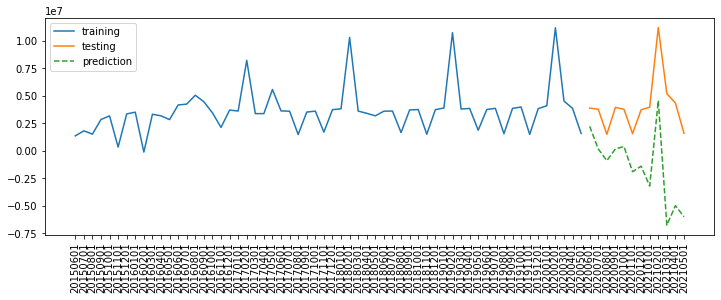

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.2s finished
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4822875708344.851, tolerance: 25621517026.094162
  model = cd_fast.enet_coordinate_descent(


Mean absolute error:  5495278.307135395


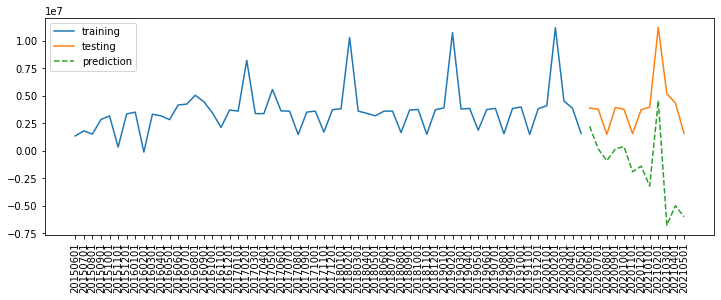

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.3s finished
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4824999000741.943, tolerance: 25621517026.094162
  model = cd_fast.enet_coordinate_descent(


Mean absolute error:  5525793.396209673


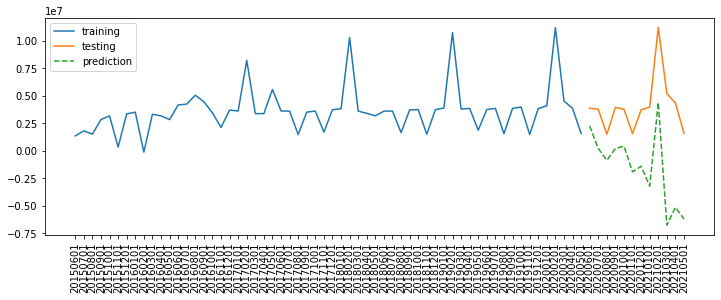

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.2s finished
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4834722629871.677, tolerance: 25621517026.094162
  model = cd_fast.enet_coordinate_descent(


Mean absolute error:  5361056.454878834


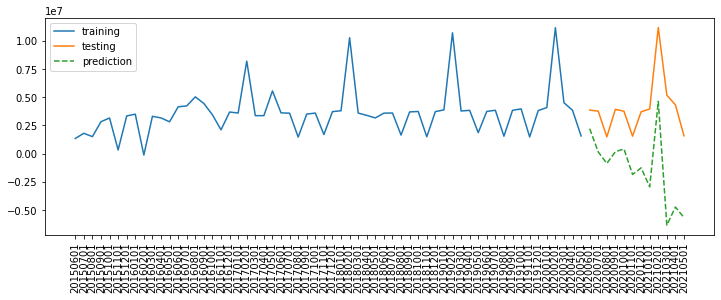

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.2s finished
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4836750921253.264, tolerance: 25621517026.094162
  model = cd_fast.enet_coordinate_descent(


Mean absolute error:  5433468.218553865


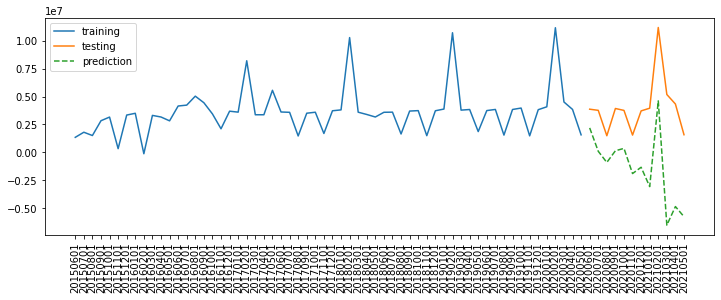

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.2s finished
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\sklearn\pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5153295276527.698, tolerance: 25621517026.094162
  model = cd_fast.enet_coordinate_descent(


Mean absolute error:  5437522.708534419


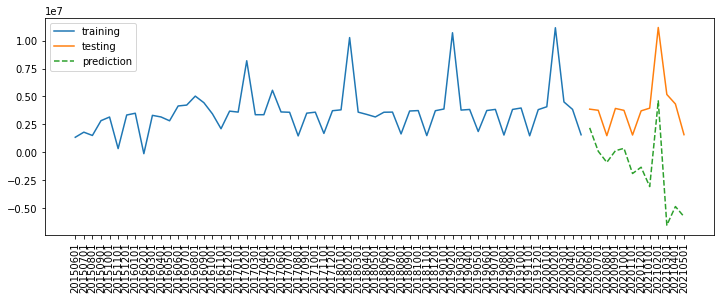

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.1s finished
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\sklearn\pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5184755286850.645, tolerance: 25621517026.094162
  model = cd_fast.enet_coordinate_descent(


Mean absolute error:  4906194.921567853


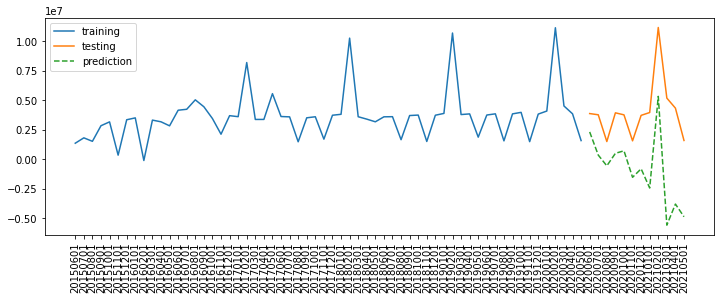

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.1s finished
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\sklearn\pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5215554764736.642, tolerance: 25621517026.094162
  model = cd_fast.enet_coordinate_descent(


Mean absolute error:  4470371.489812637


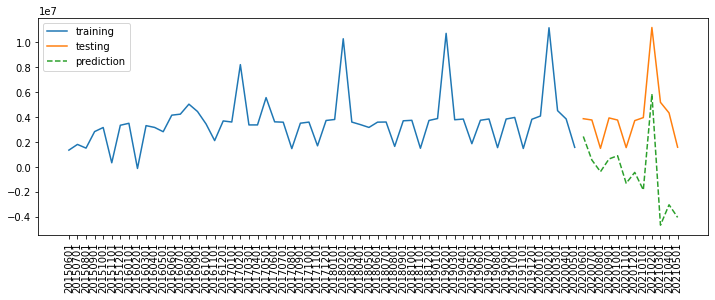

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.2s finished
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\sklearn\pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5291311024562.859, tolerance: 25621517026.094162
  model = cd_fast.enet_coordinate_descent(


Mean absolute error:  4112820.397936053


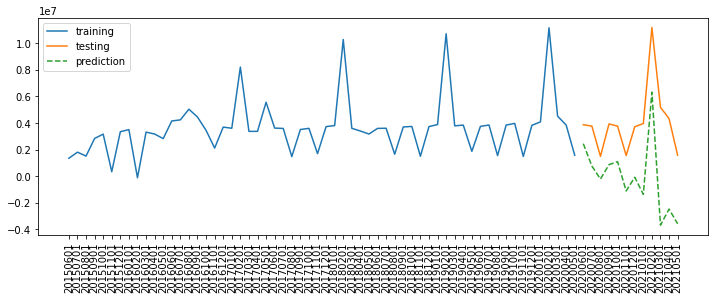

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.1s finished
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\sklearn\pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5294087557465.432, tolerance: 25621517026.094162
  model = cd_fast.enet_coordinate_descent(


Mean absolute error:  4027663.697121173


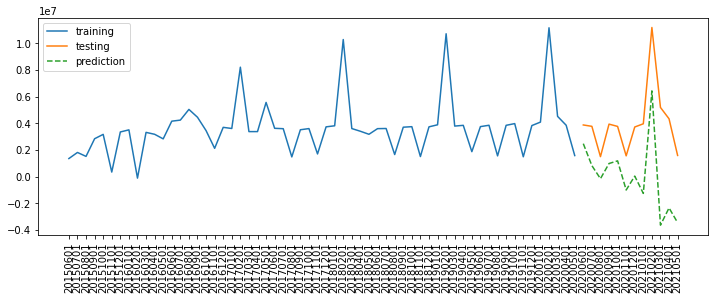

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.1s finished
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\sklearn\pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5464795790463.24, tolerance: 25621517026.094162
  model = cd_fast.enet_coordinate_descent(


Mean absolute error:  3945498.506189801


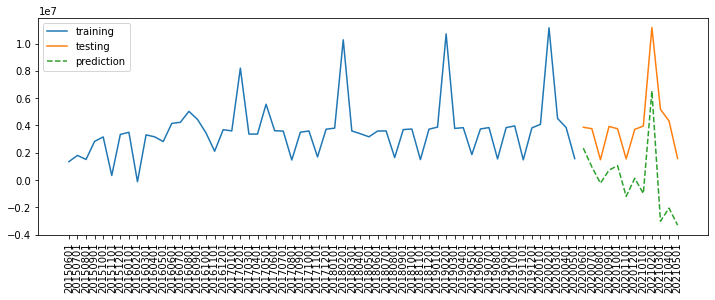

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.2s finished
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\sklearn\pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5468260772465.052, tolerance: 25621517026.094162
  model = cd_fast.enet_coordinate_descent(


Mean absolute error:  3926180.3509097374


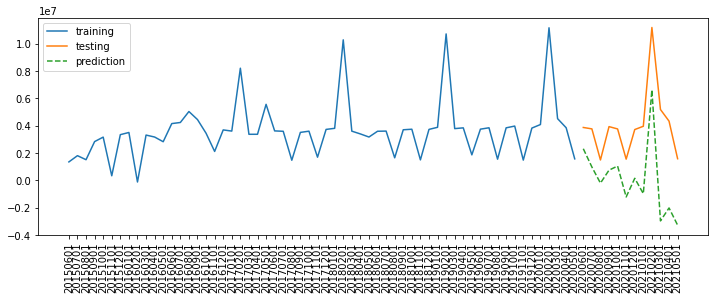

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.1s finished
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\sklearn\pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5589533393143.256, tolerance: 25621517026.094162
  model = cd_fast.enet_coordinate_descent(


Mean absolute error:  3884720.9243103904


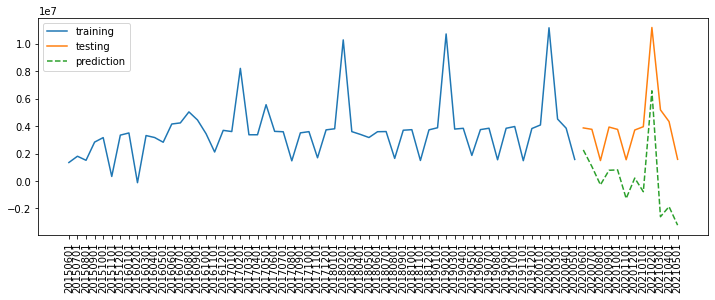

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.1s finished
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\sklearn\pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5679018744119.117, tolerance: 25621517026.094162
  model = cd_fast.enet_coordinate_descent(


Mean absolute error:  3668567.8192671095


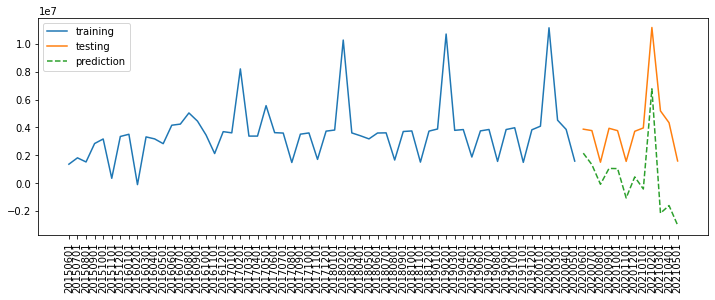

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.1s finished
c:\users\bruno.gonzalez\miniconda3\envs\pyca\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5284283692096.994, tolerance: 25621517026.094162
  model = cd_fast.enet_coordinate_descent(


Mean absolute error:  4098164.5965625513


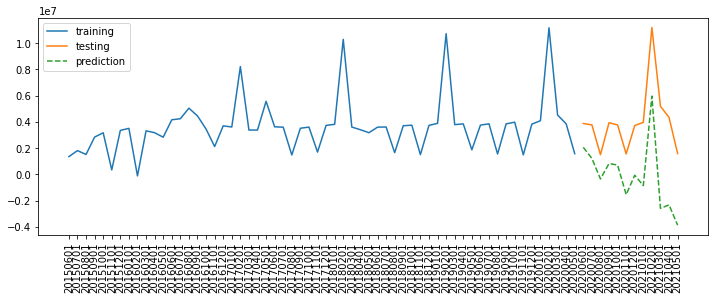

In [250]:
n_iter = 20
X_train_it = X_train.copy()
X_test_it = X_test.copy()
var_droped = []
mae_it = [y_train.abs().sum(),y_train.abs().sum()]
while mae_it[-1]*0.9 <= mae_it[-2]:
#for i in range(n_iter):
    best_model = gs_lasso
    gs_lasso = GridSearchCV(pipe, param_grid, n_jobs=2, verbose=1)
    gs_lasso.fit(X_train_it, y_train)
    coef = pd.DataFrame(gs_lasso.best_estimator_.named_steps["model"].coef_,
                        index = X_train_it.columns,
                        columns=['coefficient'])
    v = coef.abs().sort_values(['coefficient']).index[0]

    y_pred_gslasso = gs_lasso.predict(X_test_it)

    mae = mean_absolute_error(y_test, y_pred_gslasso)
    print("Mean absolute error: ", mae)
    mae_it.append(mae)

    fig, ax = plt.subplots(figsize=(12,4))

    ax.plot(y_train, label='training')
    ax.plot(y_test, label='testing')
    ax.plot(pd.DataFrame(y_pred_gslasso).set_index(y_test.index), label='prediction', ls="--")
    # Define the date format
    plt.xticks(rotation = 90)
    plt.legend()
    plt.show()

    X_train_it = X_train_it.drop(v, axis=1)
    X_test_it = X_test_it.drop(v, axis=1)
    var_droped.append(v)

In [251]:
var_droped

['month_07',
 'month_12',
 'month_05',
 'DGORDER',
 'FYFR',
 'month_04',
 'month_01',
 'month_03',
 'CIVPART',
 'month_09',
 'DEXUSEU',
 'month_10',
 'month_06',
 'DEXCHUS',
 'FYFSD']

In [254]:
len(var_droped)

15

<BarContainer object of 15 artists>

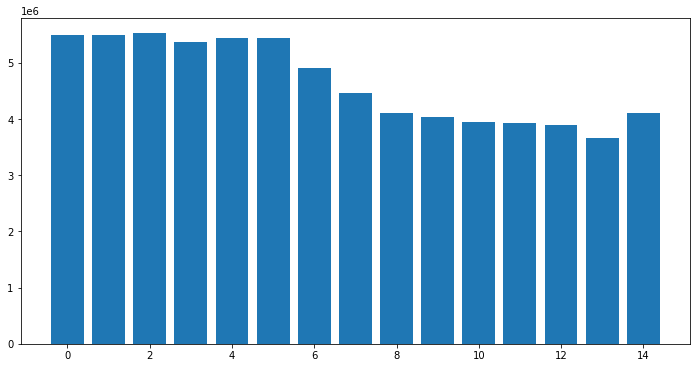

In [252]:
fig, ax = plt.subplots(figsize=(12,6))

ax.bar(np.arange(len(mae_it[2:])), mae_it[2:])

In [253]:
y_pred_gslasso = best_model.predict(X_test.drop(var_droped[:-2], axis=1))

mae = mean_absolute_error(y_test, y_pred_gslasso)
print("Mean absolute error: ", mae)

Mean absolute error:  3668567.8192671095


In [170]:
coef.sort_values(['coefficient'], ascending=False)

,coefficient
CIVPART,9.610689e+06
401(K) PLANS5600 401K ADMINISTRATIONAverage Asset Values - Calculated - RW,9.127539e+06
FYFR,8.153969e+06
401(K) PLANS5600 401K ADMINISTRATIONAverage Assets/Clients - Calculated - RW,7.297873e+06
PRD351ASO5600 401K ADMINISTRATIONLosses - RW,5.316908e+06
...,...
PRD351RRS5600 401K ADMINISTRATIONLoss % of BCB,-6.110339e+06
IRA SIMPLE5600 401K ADMINISTRATIONEnding Client Base - RW,-6.213080e+06
month_06,-6.365900e+06
INDPRO,-6.527314e+06


<AxesSubplot:>

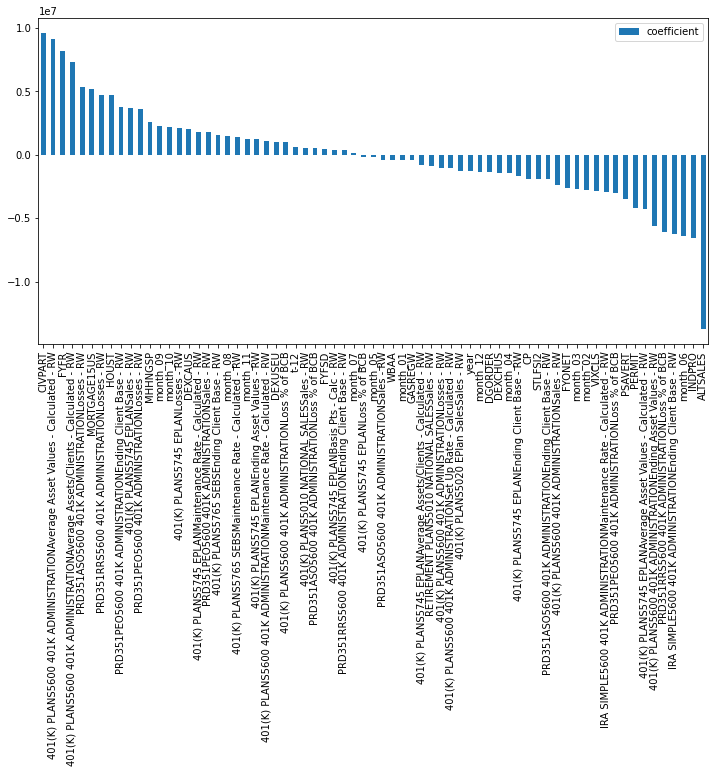

In [168]:
coef.sort_values(['coefficient'], ascending=False).plot.bar(figsize=(12,6))

In [162]:
gs_lasso.best_estimator_.named_steps["model"].coef_

array([   574782.04880925,  -3412268.7003571 ,   8142579.31365146,
        -2675926.36700964,    427560.09444922,   9485488.14246306,
        -6481584.06798228, -13680361.61996114,  -1333288.52870838,
        -1888115.98889134,   4648912.43294822,  -4096603.59580855,
         -398085.76959801,   2552924.2953372 ,  -2846711.66618609,
        -1866556.17632668,   -350477.5427285 ,   5138546.73980385,
         1050197.73925247,  -1375557.68413274,   2015513.13782346,
          562512.27383553,  -1215022.9964377 ,   9039643.72381111,
         7182161.75317095,         0.        ,  -5584641.90384069,
          -79089.41737655,    973070.89145201,  -1044184.50312562,
         1064339.90288277,  -2386470.21227873,  -1049202.48936189,
        -3966465.11641802,   -865007.73704999,    407211.83073985,
         1254211.22502589,  -1682808.33090024,   -209163.70018888,
         2071454.12550958,   1820059.53534771,   3681307.41478999,
         1596145.62320682,   1394851.52080414,  -6186258.11446

In [144]:
y_pred_gslasso = gs_lasso.predict(X_test)

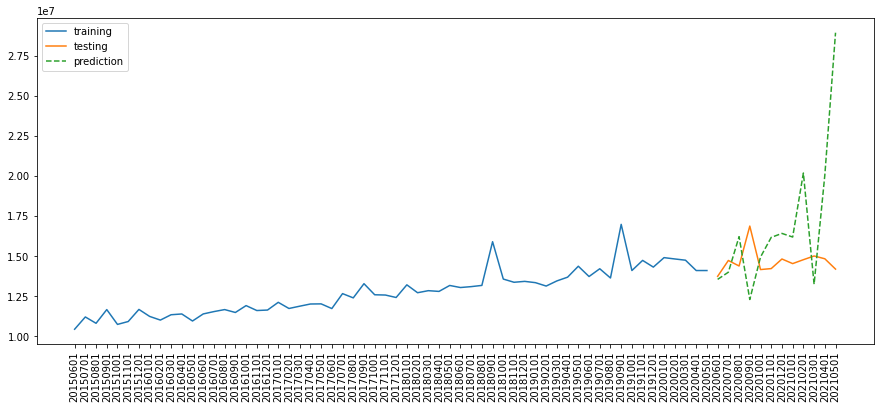

In [145]:
fig, ax = plt.subplots(figsize=(15,6))

# y_train.plot(ax=ax)
# y_test.plot(ax=ax)
ax.plot(y_train, label='training')
ax.plot(y_test, label='testing')
ax.plot(pd.DataFrame(y_pred_gslasso).set_index(y_test.index), label='prediction', ls="--")
# Define the date format
plt.xticks(rotation = 90)
plt.legend()

## Gradient boosting

In [26]:
from sklearn.ensemble import GradientBoostingRegressor

In [27]:
model_gb = GradientBoostingRegressor()

In [28]:
parameters = {'learning_rate':[0.1, 0.5],
              'n_estimators': [100],
              'max_depthint': [3]}

In [ ]:
n_iter = 20
X_train_it = X_train.copy()
X_test_it = X_test.copy()
var_droped = []
mae_it = [y_train.abs().sum(),y_train.abs().sum()]
gs_gb = model_gb
while mae_it[-1]*0.9 <= mae_it[-2]:
#for i in range(n_iter):
    best_model = gs_gb
    gs_gb = GridSearchCV(model_gb, parameters, n_jobs=3, verbose=1)
    gs_gb.fit(X_train_it, y_train)
    coef = pd.DataFrame(gs_gb.best_estimator_.feature_importances_,
                        index = X_train_it.columns,
                        columns=['coefficient'])
    v = coef.abs().sort_values(['coefficient']).index[0]

    y_pred_gsgb = gs_gb.predict(X_test_it)

    mae = mean_absolute_error(y_test, y_pred_gsgb)
    print("Mean absolute error: ", mae)
    mae_it.append(mae)

    fig, ax = plt.subplots(figsize=(12,4))

    ax.plot(y_train, label='training')
    ax.plot(y_test, label='testing')
    ax.plot(pd.DataFrame(y_pred_gslasso).set_index(y_test.index), label='prediction', ls="--")
    # Define the date format
    plt.xticks(rotation = 90)
    plt.legend()
    plt.show()

    X_train_it = X_train_it.drop(v, axis=1)
    X_test_it = X_test_it.drop(v, axis=1)
    var_droped.append(v)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
